In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

Load data - from raw version

torch.float32 torch.Size([36, 3, 49, 49])
torch.float32 torch.Size([36, 1])
tensor([[0.0000, 0.0000, 0.0039, 0.0039, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0039],
        [0.0039, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0039],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000]])


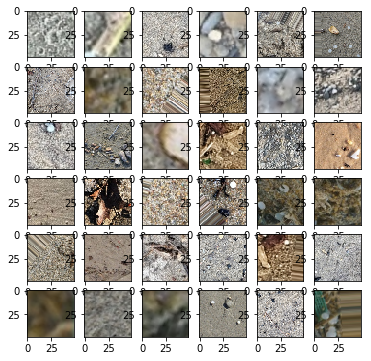

In [3]:
class RawDataset(Dataset):
    def __init__(self):
        s = 49
        self.imgin = np.fromfile("images/data_in.raw", dtype=np.uint8)
        self.imgin = self.imgin.reshape((len(self.imgin)//(3*s*s), 3, s, s))
        self.imgout = np.fromfile("images/data_out.raw", dtype=np.uint8)
        self.size = s

    def __len__(self):
        nin = self.imgin.shape[0]
        nout = len(self.imgout)
        assert nin == nout
        return nin

    def __getitem__(self, i):
        return [
            self.imgin[i].astype(np.float32) / 255.0,
            self.imgout[i:i+1].astype(np.float32) / 255.0
        ]

dataset = RawDataset()
for imgin, imgout in DataLoader(
    dataset,
    batch_size=36,
    shuffle=True
):
    print(imgin.dtype, imgin.shape)
    print(imgout.dtype, imgout.shape)
    n = int(imgin.shape[0]**0.5)

    imgout = imgout.reshape((n, n))
    print(imgout)

    imgin = np.einsum('acij->aijc', imgin.numpy())

    plt.figure(figsize=(n, n))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(imgin[i])

    plt.show()
    break

Model

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        n = 4
        model = [
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            # 3 x 33x33
            nn.Conv2d(3, n, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        for _ in range(10):
            model += [
                nn.Conv2d(n, n, 3, 1, 0, bias=False),
                nn.ZeroPad2d(-1),
                nn.BatchNorm2d(n),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        model += [
            # 3 x 5x5
            nn.Conv2d(n, 1, 3, 1, 0, bias=False),
            nn.ZeroPad2d(-1),
            # 1 x 1x1
            nn.Sigmoid()
        ]
        self.main = nn.Sequential(*model)
    
    def forward(self, x):
        return self.main(x)

model = Model()
print(model)

Model(
  (main): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): ZeroPad2d(padding=(-1, -1, -1, -1), value=0.0)
    (12): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(4, 4, kerne

Training

In [5]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
))

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.005, betas=(0.9, 0.999))


lossFun = torch.nn.BCELoss()
flatten = torch.nn.Flatten()

print("ADAM")
count = 0
for epoch in range(1, 5+1):
    print("Epoch", epoch)
    for nin, nout in dataloader:
        optimizer.zero_grad()
        output = flatten(model(nin))
        loss = lossFun(output, nout)
        loss.backward()
        optimizer.step()
        
        count += 1
        if count % 200 == 0:
            print("Iteration {} - loss = {}".format(count, loss.item()))

ADAM
Epoch 1
Iteration 200 - loss = 0.13626503944396973
Iteration 400 - loss = 0.05805568769574165
Iteration 600 - loss = 0.11589355021715164
Iteration 800 - loss = 0.23382005095481873
Iteration 1000 - loss = 0.13581007719039917
Iteration 1200 - loss = 0.24635225534439087
Iteration 1400 - loss = 0.09171881526708603
Iteration 1600 - loss = 0.10210144519805908
Epoch 2
Iteration 1800 - loss = 0.04041299968957901
Iteration 2000 - loss = 0.07670672237873077
Iteration 2200 - loss = 0.10587155073881149
Iteration 2400 - loss = 0.13501133024692535
Iteration 2600 - loss = 0.07961954176425934
Iteration 2800 - loss = 0.1451875865459442
Iteration 3000 - loss = 0.17509396374225616
Iteration 3200 - loss = 0.05556241050362587
Iteration 3400 - loss = 0.11526787281036377
Epoch 3
Iteration 3600 - loss = 0.04793365299701691
Iteration 3800 - loss = 0.08433783054351807
Iteration 4000 - loss = 0.09319379925727844
Iteration 4200 - loss = 0.04985251650214195
Iteration 4400 - loss = 0.0870114117860794
Iteration

Calculate running mean and variance

In [6]:
for layer in model.main:
    if layer.__class__.__name__ == "BatchNorm2d":
        layer.track_running_stats = True  # unfreeze

dataloader = list(DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True
))

for nin, nout in dataloader:
    with torch.no_grad():
        output = flatten(model(nin))
        loss = lossFun(output, nout)
        print(loss)

tensor(0.1076)


Export

In [7]:
import os
os.system("rm weights/*")

param_i = 0
bn_i = 0
bns = []
for param in model.parameters():
    data = param.data
    shape = '_'.join(map(str, data.shape))
    if len(data.shape) == 1:
        name = "bn{:02d}{}".format(bn_i//2, bn_i%2)
        bns.append((name, data))
        bn_i += 1
        continue
    name = "w{:02d}_{}".format(param_i, shape)
    data.numpy().astype(np.float32).tofile("weights/"+name+".bin")
    param_i += 1

bn_i = 0
for layer in model.main:
    if layer.__class__.__name__ != "BatchNorm2d":
        continue
    layer.track_running_stats = False  # freeze
    mu = layer.running_mean
    var = layer.running_var
    name = "bn{:02d}2".format(bn_i)
    bns.append((name, mu))
    name = "bn{:02d}3".format(bn_i)
    bns.append((name, var))
    bn_i += 1

bns.sort()
for name, data in bns:
    s = '[' + ', '.join(map(str, data.numpy())) + ']'
    print(f"{name}: {s},")

bn000: [0.94665104, 0.59426117, 1.5797169],
bn001: [0.15600169, 0.52960825, -0.15991947],
bn002: [0.58163226, 0.5417935, 0.49379724],
bn003: [0.030006414, 0.028704993, 0.030156357],
bn010: [0.8697908, 1.5291777, 0.79843074, 1.1721553],
bn011: [0.121736, 0.3153709, -0.47843263, -0.36877862],
bn012: [0.2982664, -1.238002, -0.93849313, -0.28683752],
bn013: [1.6743089, 3.7136486, 2.557784, 7.5691075],
bn020: [0.9858964, 1.1256979, 0.50308096, 1.6949637],
bn021: [-0.7857607, -0.85414904, -0.3106519, 0.039859094],
bn022: [-0.60801166, 0.16762815, 1.46261, 0.5373689],
bn023: [4.076964, 2.3419323, 1.7342334, 7.652547],
bn030: [1.3982179, 0.74577457, 1.2829815, 1.3810416],
bn031: [0.12163788, -0.6373562, -0.24187645, -0.27386954],
bn032: [-1.4886609, -1.3211839, -0.5807669, -1.9406786],
bn033: [16.506697, 7.109826, 4.244896, 22.790646],
bn040: [0.79484713, 1.6376235, 0.52649885, 0.99452925],
bn041: [0.5975516, 0.08047055, -0.5244208, -0.33221477],
bn042: [-1.104423, -1.6284555, 0.5159568, 0.277